# Healing Hugs Exploratory Analysis
Summary: This analysis looks at several variables to see if they are correlated to a husband receiving a healing hug from his wife. 

What is a healing hug, you ask? Just as one can consciously feel a physiological reponse to stress (think about when you are super stressed and your body physically feels different), this husband reports that with some hugs with his wife, he can feel the physiological reponse of muscle relaxation and lowered stressed. He presumes that during these hugs, his body releases healing hormones (or receives at least some form of healing).  

As he claims these are healthy, he would like to receive as many of these as possible. Who wouldn't?! 

For years, the husband wondered if his wife's work schedule and workout status affected whether or not he receives one. He had no hard evidence. However, once he discovered I was getting into data science, he began recording some variables with the hope one day I would be able to provide insight. After nearly 2.5 years, that day has come. 

At his request, I redacted the data to some extent prior to puclic exposure. The end of that redaction is where this project begins: healing_hugs.csv.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

# Data exploration
Let's read in the data and see what we have...

In [3]:
raw = pd.read_csv('healing_hugs.csv')
raw.head()

,Day_of_week,Workout,Work_shift,Healing_hug,Month,Year,Pto
0,Sun,1.0,on call,0.0,8,2021,0
1,Mon,0.0,late,1.0,8,2021,0
2,Tue,0.0,late,0.0,8,2021,0
3,Wed,0.0,late,0.0,9,2021,0
4,Thu,NaN,late,NaN,9,2021,0


"Workout" = Did the wife workout?
"Work_shift" = The wife's work shift starting a 6am, 7-8am, or 9am for 'early', 'mid', and 'late', respectively. 'on-call' is on Sunday's only.
"Healing_hug" = Did the husband receive a healing hug?
"Pto" = Was the wife on paid-time-off (PTO)?

Immediately, we see NaN's so we will need to preprocess the data. Further, we have categorical and numerical features; these will need to be handled differently. The husband indicates any "blank" value should be "none" or 0, so that prevents us from having to impute or ignore observations.

<Axes: >

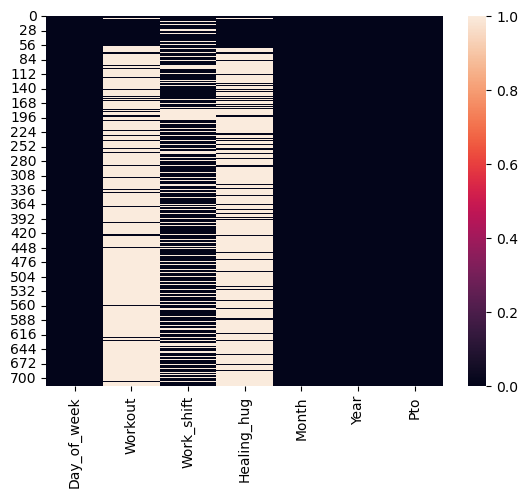

In [5]:
# To get a better idea of NaN's, lets quickly inspect a heatmap
sns.heatmap(raw.isnull())

In [13]:
# Create a new dataframe in case we need the original later
hh = raw.copy(deep=True)
# Because "Work_shift" is categorical, we will address it first, then fill the rest with 0
hh = hh.fillna({"Work_shift": "none"}).fillna(0)

In [20]:
# check unique values
for col in hh:
    print(col + str(hh[col].unique()))

Day_of_week['Sun' 'Mon' 'Tue' 'Wed' 'Thu' 'Fri' 'Sat']
Workout[1. 0.]
Work_shift['on call' 'late' 'early' 'none' 'mid']
Healing_hug[0. 1.]
Month[ 8  9 10 11 12  1  2  3  4  5  6  7]
Year[2021 2022 2023 2024]
Pto[0 1]


In [27]:
# Clean up a few items:
# Work_shift "off" is same as "none", so refine those values
hh.Work_shift.replace(to_replace="off", value="none", inplace=True)
# We don't need the extra spaces in 'early '
hh.Work_shift = hh.Work_shift.str.strip()

In [28]:
# Three values in our target column, "Healing_hug", will affect how we do logistic regression. Let's investigate further...
hh.Healing_hug.value_counts()

0.0    600
1.0    115
Name: Healing_hug, dtype: int64

In [26]:
# Okay, easy enough. Let's convert that lone 2 to a 1. It will not alter the anaylsis in any significant way. We will use binary logistic regression.
hh.Healing_hug.replace(to_replace=2, value=1, inplace=True)

Day_of_week['Sun' 'Mon' 'Tue' 'Wed' 'Thu' 'Fri' 'Sat']
Workout[1. 0.]
Work_shift['on call' 'late' 'early' 'none' 'mid']
Healing_hug[0. 1.]
Month[ 8  9 10 11 12  1  2  3  4  5  6  7]
Year[2021 2022 2023 2024]
Pto[0 1]


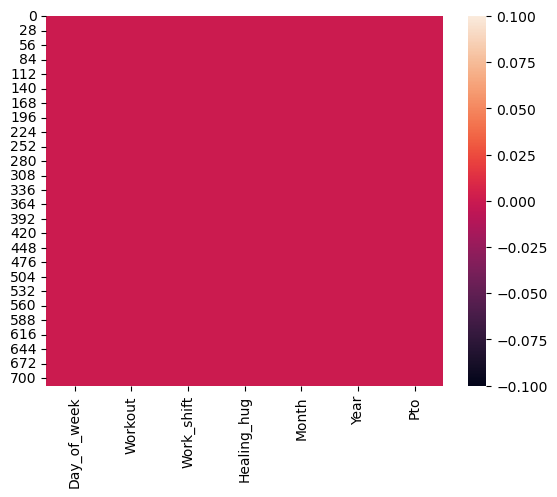

In [25]:
# Let's confirm the data is how we want
sns.heatmap(hh.isnull())
for col in hh:
    print(col + str(hh[col].unique()))


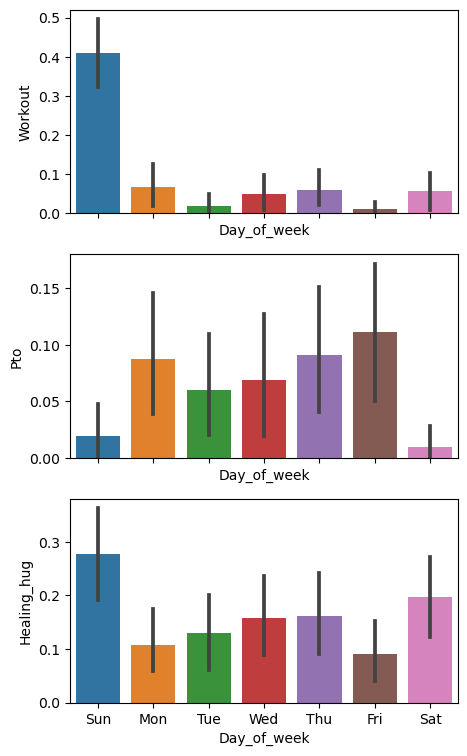

In [37]:
# Looks good, let's do some exploratory analysis with bar graphs to 1. visualize any trends and 2. ensure we have enough data for regression.
x = hh.Day_of_week
ys = ["Workout", "Pto", "Healing_hug"]

fig, axes = plt.subplots(nrows=len(ys), sharex=True)
fig.set_size_inches(5, 9)

for i in range(len(ys)):
    sns.barplot(x=x, 
                y=hh[ys[i]],
                ax=axes[i],)

### Workout vs Day_of_week
The day of week certainly seems to be highly correlated with whether or not the wife works out. After sharing these results with the husband, he revealed they take turns on the weekend working out because of their family situation; Sunday is typically her day to go. 

### Pto vs Day_of_week
Nothing too surprising here. Most people take PTO during the week. 

### Healing_hug
It appears the husband is more likely to receive a healing hug on the weekend compared to during the week, with the highest chance on Sunday. Because Sunday is highly correlated to the wife working out, teasing out to what degree working out affects the chances of a healing hug will be interesting. We may need to group the days of the week as "Sunday" and "Non-Sunday" to ensure we have enough data for a strong analysis.

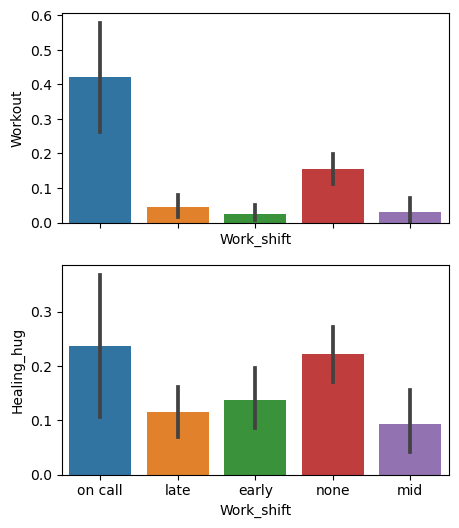

In [38]:
x = hh.Work_shift
ys = ["Workout", "Healing_hug"]

fig, axes = plt.subplots(nrows=len(ys), sharex=True)
fig.set_size_inches(5, 6)

for i in range(len(ys)):
    sns.barplot(x=x, 
                y=hh[ys[i]],
                ax=axes[i],)

### Workout vs Work_shift
Work shift seems to be correlated with work out status, which compounds those features. 

### Healing_hug vs Work_shift
The chances of a healing hug does seem to be correlated with work shift. However, reall that shifts 'early', 'mid', and 'late' correspond to only weekdays, while 'none' and 'on-call' are nearly always weekends. The means and errors of 'early', 'mid', and 'late' shifts all fall within each other. This likely means the specific weekday shift has little to no correlation  "within" those three shifts

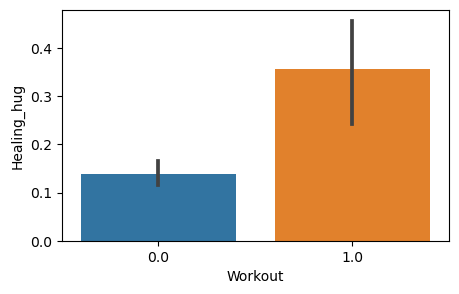

In [39]:
x = hh.Workout
ys = ["Healing_hug"]

fig, axes = plt.subplots(nrows=len(ys), sharex=True)
fig.set_size_inches(5, 3)

for i in range(len(ys)):
    sns.barplot(x=x, 
                y=hh[ys[i]])